# Import libraries

In [ ]:
from urllib.parse import urlparse, parse_qs
from youtube_transcript_api import YouTubeTranscriptApi
from wordcloud import WordCloud, ImageColorGenerator
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import numpy as np
import pandas as pd
import datetime
from PIL import Image
import requests
from bs4 import BeautifulSoup
import PyPDF2 
from urllib.request import urlretrieve
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO
import itertools

In [3]:
URL = "https://es.wikipedia.org/wiki/Anexo:Presidentes_de_la_Naci%C3%B3n_Argentina"

table_class="wikitable sortable jquery-tablesorter"
response=requests.get(URL)
print(response.status_code)

200


In [ ]:
soup = BeautifulSoup(response.text, 'html.parser')
data=soup.find('table',{'class':"wikitable"})
df=pd.read_html(str(data))
data_table=pd.DataFrame(df[0])

# EDA

In [6]:
data_table.tail()

,Presidente de la Nación,Presidente de la Nación.1,Presidente de la Nación.2,Provincia en la que nació,Periodo presidencial,Inicio del mandato,Fin del mandato,Duración,Partido,Elecciones,Vicepresidente,Vicepresidente.1,Unnamed: 12
62,NaN,NaN,Néstor Kirchner(1950 – 2010)[34]​,Santa Cruz,2003 - 2007,25 de mayo de 2003 [n 20]​,10 de diciembre de 2007,"4 años, 6 meses y 16 días",Partido JusticialistaFrente para la Victoria,2003,NaN,Daniel Scioli,NaN
63,NaN,NaN,Cristina Fernández de Kirchner(n. 1953),Provincia de Buenos Aires,2007 - 2011,10 de diciembre de 2007,10 de diciembre de 2011,8 años,Partido JusticialistaFrente para la Victoria,2007,NaN,Julio Cobos,NaN
64,NaN,NaN,Cristina Fernández de Kirchner(n. 1953),Provincia de Buenos Aires,2011 - 2015,10 de diciembre de 2011,9 de diciembre de 2015 [n 21]​,8 años,Partido JusticialistaFrente para la Victoria,2011,NaN,Amado Boudou,NaN
65,NaN,NaN,Mauricio Macri(n. 1959),Provincia de Buenos Aires,2015 - 2019,10 de diciembre de 2015 [n 21]​,10 de diciembre de 2019,4 años,Propuesta RepublicanaCambiemos,2015,NaN,Gabriela Michetti,NaN
66,NaN,NaN,Alberto Fernández(n. 1959),Ciudad de Buenos Aires,2019 - 2023,10 de diciembre de 2019,Actualmente en el cargo,"2 años, 3 meses y 2 días",Partido JusticialistaFrente de Todos,2019,NaN,Cristina Fernández de Kirchner,NaN


In [7]:
df_table = data_table[['Presidente de la Nación.2','Inicio del mandato','Fin del mandato','Partido']]
df_table.rename(columns={'Presidente de la Nación.2': "Presidente",'Inicio del mandato':'Inicio_mandato','Fin del mandato':'Fin_mandato' }, inplace=True)

<ipython-input-7-7c8f678cfc2c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_table.rename(columns={'Presidente de la Nación.2': "Presidente",'Inicio del mandato':'Inicio_mandato','Fin del mandato':'Fin_mandato' }, inplace=True)


In [8]:
df_table.tail()

,Presidente,Inicio_mandato,Fin_mandato,Partido
62,Néstor Kirchner(1950 – 2010)[34]​,25 de mayo de 2003 [n 20]​,10 de diciembre de 2007,Partido JusticialistaFrente para la Victoria
63,Cristina Fernández de Kirchner(n. 1953),10 de diciembre de 2007,10 de diciembre de 2011,Partido JusticialistaFrente para la Victoria
64,Cristina Fernández de Kirchner(n. 1953),10 de diciembre de 2011,9 de diciembre de 2015 [n 21]​,Partido JusticialistaFrente para la Victoria
65,Mauricio Macri(n. 1959),10 de diciembre de 2015 [n 21]​,10 de diciembre de 2019,Propuesta RepublicanaCambiemos
66,Alberto Fernández(n. 1959),10 de diciembre de 2019,Actualmente en el cargo,Partido JusticialistaFrente de Todos


In [9]:
df_table = df_table.iloc[-13:]

In [10]:
df_table['Presidente'] = df_table.Presidente.str.partition('(')[0]
df_table['Partido'] = df_table.Partido.str.partition('[')[0]
df_table.tail()

,Presidente,Inicio_mandato,Fin_mandato,Partido
62,Néstor Kirchner,25 de mayo de 2003 [n 20]​,10 de diciembre de 2007,Partido JusticialistaFrente para la Victoria
63,Cristina Fernández de Kirchner,10 de diciembre de 2007,10 de diciembre de 2011,Partido JusticialistaFrente para la Victoria
64,Cristina Fernández de Kirchner,10 de diciembre de 2011,9 de diciembre de 2015 [n 21]​,Partido JusticialistaFrente para la Victoria
65,Mauricio Macri,10 de diciembre de 2015 [n 21]​,10 de diciembre de 2019,Propuesta RepublicanaCambiemos
66,Alberto Fernández,10 de diciembre de 2019,Actualmente en el cargo,Partido JusticialistaFrente de Todos


In [11]:
def change_str_column_to_date(column): # name of the column as string

    dia = df_table[column].str.split('de',expand=True)[0].replace({"Actualmente en el cargo": str(datetime.datetime.now().day)," ":""},regex=True)
    mes = df_table[column].str.split('de',expand=True)[1].replace({None: str(datetime.datetime.now().month)," ":""},regex=True)
    anio = df_table[column].str.split('de',expand=True)[2].replace({None: str(datetime.datetime.now().year)," ":""},regex=True).str.split('\xa0',expand=True)[0]
    meses = {
        'enero': "01",
        'febrero': "02",
        'marzo': "03",
        'abril': "04",
        'mayo': "05",
        'junio': "06",
        'julio': "07",
        'agosto': "08",
        'septiembre': "09",
        'octubre': "10",
        'noviembre': "11",
        'diciembre': "12"
        }

    num_mes = mes.replace(meses)
    num_mes
    fecha_str = dia + '-'+ num_mes + '-' + anio
    fecha = pd.to_datetime(fecha_str,dayfirst=True)
    df_table[column + '_fecha'] = fecha 
    

In [12]:
change_str_column_to_date('Inicio_mandato')
change_str_column_to_date('Fin_mandato')

In [13]:
df_table.tail()

,Presidente,Inicio_mandato,Fin_mandato,Partido,Inicio_mandato_fecha,Fin_mandato_fecha
62,Néstor Kirchner,25 de mayo de 2003 [n 20]​,10 de diciembre de 2007,Partido JusticialistaFrente para la Victoria,2003-05-25,2007-12-10
63,Cristina Fernández de Kirchner,10 de diciembre de 2007,10 de diciembre de 2011,Partido JusticialistaFrente para la Victoria,2007-12-10,2011-12-10
64,Cristina Fernández de Kirchner,10 de diciembre de 2011,9 de diciembre de 2015 [n 21]​,Partido JusticialistaFrente para la Victoria,2011-12-10,2015-12-09
65,Mauricio Macri,10 de diciembre de 2015 [n 21]​,10 de diciembre de 2019,Propuesta RepublicanaCambiemos,2015-12-10,2019-12-10
66,Alberto Fernández,10 de diciembre de 2019,Actualmente en el cargo,Partido JusticialistaFrente de Todos,2019-12-10,2022-03-16


In [14]:
df_table.drop(columns= ['Inicio_mandato','Fin_mandato'], axis=1,inplace=True)

## Tabla de presidentes

In [15]:
df_table = df_table.drop(labels=[56,59], axis=0).reset_index(drop=True)
df_table['duracion_anios'] = df_table.Fin_mandato_fecha.dt.year - df_table.Inicio_mandato_fecha.dt.year
df_table

,Presidente,Partido,Inicio_mandato_fecha,Fin_mandato_fecha,duracion_anios
0,Raúl Alfonsín,Unión Cívica Radical,1983-12-10,1989-07-08,6
1,Carlos Menem,Partido JusticialistaFREJUPO,1989-07-08,1995-07-08,6
2,Carlos Menem,Partido Justicialista,1995-07-08,1999-12-10,4
3,Fernando de la Rúa,Unión Cívica RadicalAlianza,1999-12-10,2001-12-21,2
4,Adolfo Rodríguez Saá,Partido Justicialista,2001-12-23,2001-12-30,0
5,Eduardo Duhalde,Partido Justicialista,2002-01-02,2003-05-25,1
6,Néstor Kirchner,Partido JusticialistaFrente para la Victoria,2003-05-25,2007-12-10,4
7,Cristina Fernández de Kirchner,Partido JusticialistaFrente para la Victoria,2007-12-10,2011-12-10,4
8,Cristina Fernández de Kirchner,Partido JusticialistaFrente para la Victoria,2011-12-10,2015-12-09,4
9,Mauricio Macri,Propuesta RepublicanaCambiemos,2015-12-10,2019-12-10,4


## Duración de mandato

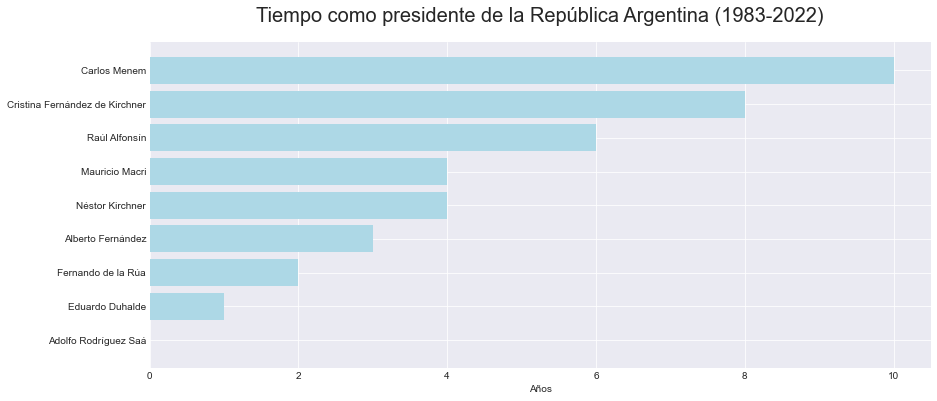

In [16]:
plt.figure(figsize=(14,6))

values = df_table.groupby('Presidente').sum().sort_values('duracion_anios',ascending=False)['duracion_anios']

plt.barh(values.index,values,color='lightblue')
plt.title("Tiempo como presidente de la República Argentina (1983-2022)",{'fontsize':20},pad=20)
plt.xlabel("Años")
plt.gca().invert_yaxis()

plt.show()

# Wordcloud

## Create Wordcloud with flag mask

In [17]:
def wordcloud_asuncion_presidencial(presidente,link,inicio_min,inicio_seg,final_min,final_seg):
    print(presidente)
    video_id = parse_qs(urlparse(link).query)["v"][0]
    script = YouTubeTranscriptApi.get_transcript(video_id, languages=("es",))

    inicio_segundos = inicio_min * 60 + inicio_seg
    final_segundos = final_min * 60 + final_seg
    
    filtrado = []

    for i in script:
        if (i['start'] >= inicio_segundos) & (i['start'] <= final_segundos):
            filtrado.append(i)

    lista = [item["text"] for item in filtrado]

    texto = " ".join(lista).lower()
    tokenizado = word_tokenize(texto)

    newStopWords = ['que','el','del','es','la'  , 'de','un','son','tambien','porque', 'cuando' , 
    'lo' , 'su' , 'pueden' ,'hacer' , 'le' , 'esto' , 'nadie' , 'yo' , 'mas' , 'hasta' , 
    'por' , 'da' , 'mi' , 'ni' ,'estan' , 'todo' , 'el ' , 'con' , 'por' , 'para' , 'la ' , 'eso' ,
    'nos' , 'dio' , 'ello' , 'es ' ,'un ' , 'tu' , 'donde' , 'solo' , 'nosotros' , 'mas ','hace' ,
    'toda' , 'toda ', 'si' , 'si ','lo ' , 'lo' , 'que ' , 'la' , 'tener' , ' tener' , ' la' , 'que' ,
    ' de' , 'una' , 'todo' , 'son','esta' , 'cual' , 'desde' ,' desde' , 'nada' , 'esa' , 
    'eso' ,' de ' , 'de ' ,'te','alguna',' lo','cuando', ' donde' , ' como ' , ' como' , 'como' , 
    'como ','través', 'cada','aplausos','argentina','argentino','argentinos',"si","ser","así",
    "presidente",'vamos',"toda","sino","va",'país','debe','hoy','quiero','creo','gobierno','puede','nación','pueblo',
    'política','debemos','año','nunca','siempre','todas']

    stop_words = set(stopwords.words('spanish')) 
    stop_words.update(newStopWords)

    tokenizado_filtrado = [palabra for palabra in tokenizado if palabra not in stop_words]
    texto_filtrado = " ".join(tokenizado_filtrado)

    mask = np.array(Image.open("Bandera_Argentina.jpg"))
    wordcloud = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(texto_filtrado)
    
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=(14,6))

    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")

    plt.savefig("flag_ARG_Wordcloud.png", format="png")

    plt.show()


## Create multiple wordclouds

In [18]:
##########
# ASUNCION PRESIDENTES
# Carlos Menem 1989 
# There is no video with transcription available 
##########

diccionario = {"Raúl Alfonsín (1983)":['https://www.youtube.com/watch?v=v3aNAo3MrWg',18,20,63,36], 
              'Fernando de la Rúa (1999)': ['https://www.youtube.com/watch?v=XtixFNLqxdU',11,58,47,55],
              "Eduardo Duhalde (2002)": ["https://www.youtube.com/watch?v=xjF5prWhBHA",3,2,27,33],
              "Néstor Kirchner (2003)": ["https://www.youtube.com/watch?v=1Zao4M3qXvw",0,31,49,28],
              "Cristina Fernández de Kirchner (2007)":["https://www.youtube.com/watch?v=rbHy28RWm78",15,46,60,34],
              "Mauricio Macri (2015)": ["https://www.youtube.com/watch?v=xOne7qx6M2k",11,2,37,43],
              "Alberto Fernández (2019)":["https://www.youtube.com/watch?v=en8p9qEuTI4",26,28,87,43],
              }

In [19]:
def create_all_wordclouds():
    for i in diccionario.keys():
        presidente = str(i)
        link = diccionario[i][0]
        inicio_min = diccionario[i][1]
        inicio_seg = diccionario[i][2]
        final_min = diccionario[i][3]
        final_seg = diccionario[i][4]
        wordcloud_asuncion_presidencial(presidente,link,inicio_min,inicio_seg,final_min,final_seg)        

Raúl Alfonsín (1983)


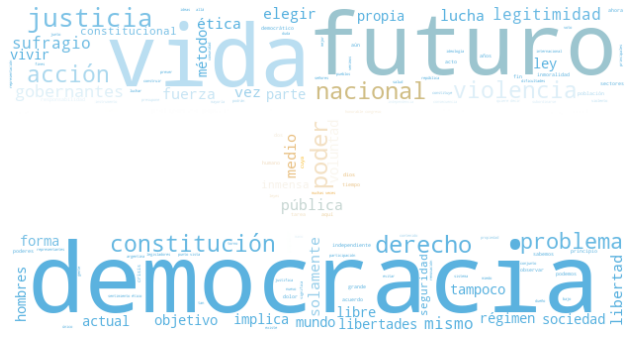

Fernando de la Rúa (1999)


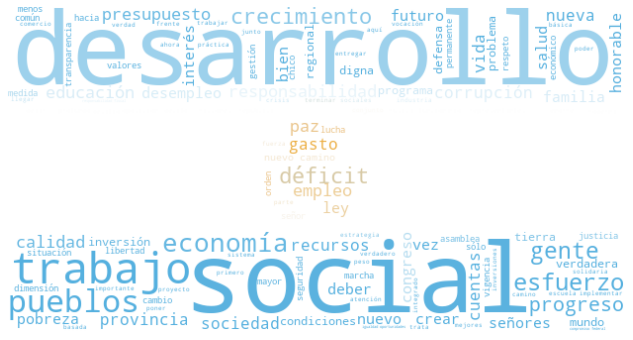

Eduardo Duhalde (2002)


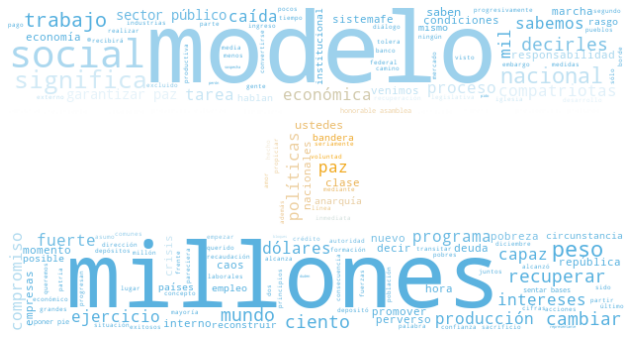

Néstor Kirchner (2003)


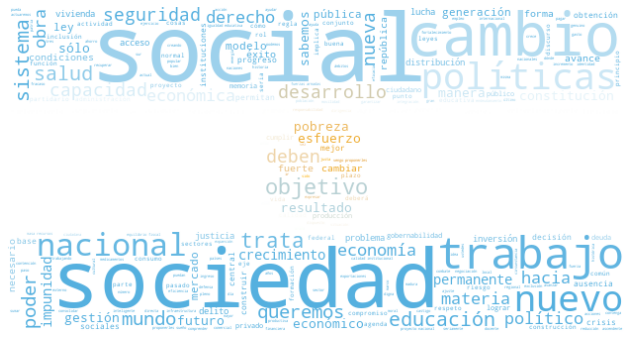

Cristina Fernández de Kirchner (2007)


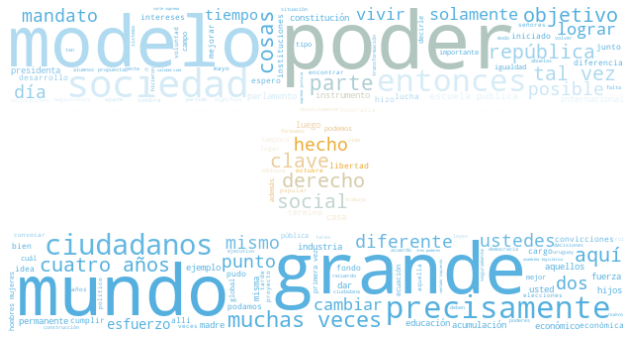

Mauricio Macri (2015)


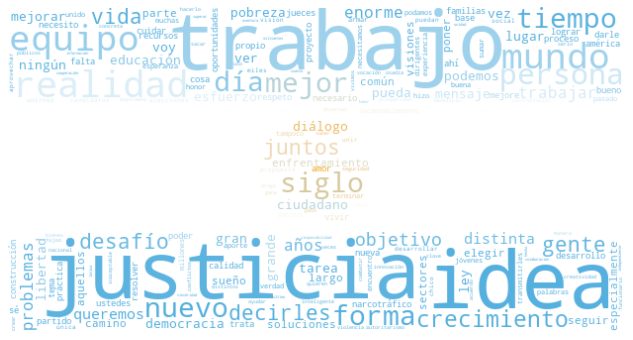

Alberto Fernández (2019)


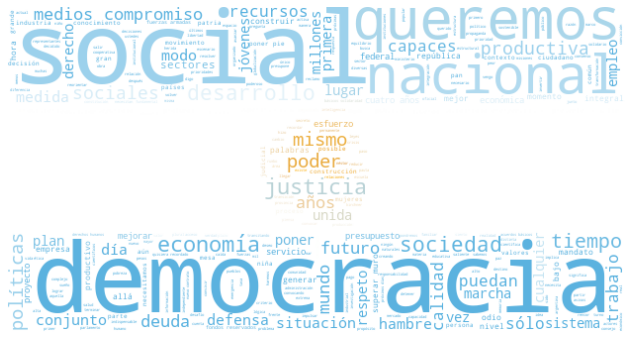

In [20]:
create_all_wordclouds()

# Duración de discurso

In [ ]:
lista_duracion = []

for i in diccionario.keys():
    presidente = str(i)
    inicio_min = diccionario[i][1]
    inicio_seg = diccionario[i][2]
    final_min = diccionario[i][3]
    final_seg = diccionario[i][4]

    inicio_minutos = inicio_min + inicio_seg / 60
    final_minutos = final_min   + final_seg / 60
    duracion_minutos = int(final_minutos-inicio_minutos)

    dict_duracion = {'Presidente': presidente,'Duracion':duracion_minutos}
    lista_duracion.append(dict_duracion)

df_duracion = pd.DataFrame(lista_duracion)
df_duracion.set_index('Presidente',inplace=True)

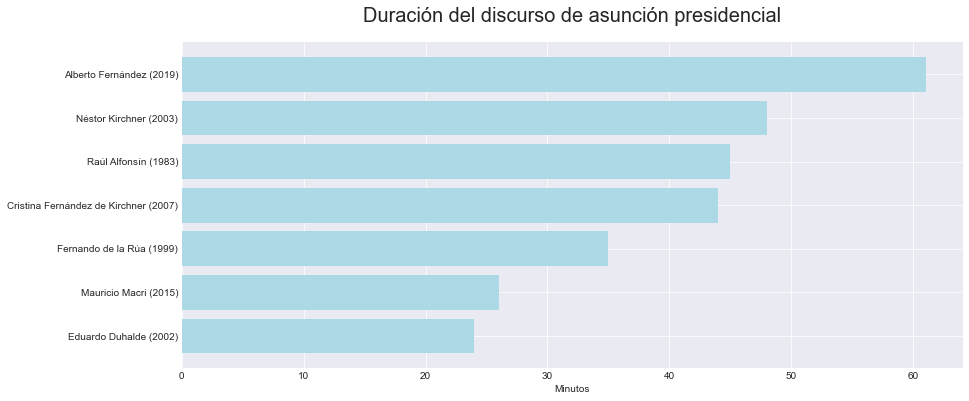

In [23]:
plt.figure(figsize=(14,6))

values_duracion = df_duracion.sort_values('Duracion')['Duracion']

plt.barh(values_duracion.index,values_duracion,color='lightblue')
plt.title("Duración del discurso de asunción presidencial",{'fontsize':20},pad=20)
plt.xlabel("Minutos")

plt.show()

# Menem (1989)

In [25]:
url = 'https://www.hcdn.gob.ar/secparl/dgral_info_parlamentaria/dip/archivos/1989-07-08_Mensaje_Presidencial_Menem_Asuncixn.pdf'

urlretrieve(url,'1989-07-08_Mensaje_Presidencial_Menem_Asuncixn.pdf')
pdfFileObj = open('1989-07-08_Mensaje_Presidencial_Menem_Asuncixn.pdf', 'rb')

In [26]:
def pdf_text_reader(pdfFileObj, pages=None):
    if pages:
        pagenums = set(pages)
    else:
        pagenums = set()

    textOutput = StringIO()
    manager = PDFResourceManager()
    converter = TextConverter(manager, textOutput, laparams=LAParams())
    interpreter = PDFPageInterpreter(manager, converter)

    infile = open(pdfFileObj, 'rb')
    for page in PDFPage.get_pages(infile, pagenums):
        interpreter.process_page(page)        
    infile.close()
    
    paras = textOutput.getvalue()   
    converter.close()
    textOutput.close
    return paras

discurso = [] 

if __name__ == '__main__': #Extract text from PDF
    for i in range(1,18):    
        out = pdf_text_reader('1989-07-08_Mensaje_Presidencial_Menem_Asuncixn.pdf', pages=[i])   
        discurso.append([i for i in out.split('\n') if i]) 

In [27]:
flat_list = list(itertools.chain(*discurso)) # Extract from discurso which is a list of lists

In [28]:
texto = " ".join(flat_list).lower() # making a string = texto 

Carlos Menem (1989)


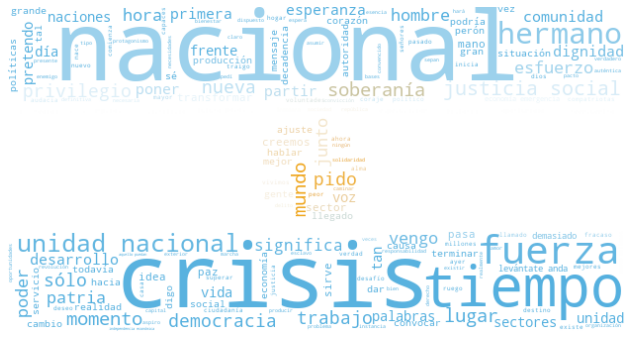

In [29]:
# Create Wordcloud

print("Carlos Menem (1989)")
tokenizado = word_tokenize(texto)

newStopWords = ['que','el','del','es','la'  , 'de','un','son','tambien','porque', 'cuando' , 
'lo' , 'su' , 'pueden' ,'hacer' , 'le' , 'esto' , 'nadie' , 'yo' , 'mas' , 'hasta' , 
'por' , 'da' , 'mi' , 'ni' ,'estan' , 'todo' , 'el ' , 'con' , 'por' , 'para' , 'la ' , 'eso' ,
'nos' , 'dio' , 'ello' , 'es ' ,'un ' , 'tu' , 'donde' , 'solo' , 'nosotros' , 'mas ','hace' ,
'toda' , 'toda ', 'si' , 'si ','lo ' , 'lo' , 'que ' , 'la' , 'tener' , ' tener' , ' la' , 'que' ,
' de' , 'una' , 'todo' , 'son','esta' , 'cual' , 'desde' ,' desde' , 'nada' , 'esa' , 
'eso' ,' de ' , 'de ' ,'te','alguna',' lo','cuando', ' donde' , ' como ' , ' como' , 'como' , 
'como ','través', 'cada','aplausos','argentina','argentino','argentinos',"si","ser","así",
"presidente",'vamos',"toda","sino","va",'país','debe','hoy','quiero','creo','gobierno','puede','nación','pueblo',
'política','debemos','año','nunca','siempre','todas']

stop_words = set(stopwords.words('spanish')) 
stop_words.update(newStopWords)

tokenizado_filtrado = [palabra for palabra in tokenizado if palabra not in stop_words]
texto_filtrado = " ".join(tokenizado_filtrado)

mask = np.array(Image.open("Bandera_Argentina.jpg"))
wordcloud = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(texto_filtrado)

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(14,6))

plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

plt.savefig("flag_ARG_Wordcloud.png", format="png")

plt.show()


# Gráficos de Wordclouds

-	Wordcloud de los discursos desde 1983 a 2019.

![](img/wordcloud1.png)
![](img/wordcloud2.png)